In [1]:
import numpy as np
import spacetrack.operators as op
from datetime import datetime,timedelta
import pandas as pd
from io import StringIO  # Import StringIO
import time
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Model training

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [4]:
# Save model
import joblib
import os
import glob

# ARIMA Models


In [5]:
resample_tle_df = pd.read_csv('../sample_dataset/sample_daily_records_data.csv')
resample_tle_df.set_index('Epoch', inplace=True)
resample_tle_df.head()

,First Derivative Mean Motion,Inclination (degrees),Right Ascension of the Ascending Node (degrees),Argument of Perigee (degrees),Mean Anomaly (degrees),Eccentricity,Mean Motion (revolutions per day),Revolution Number at Epoch
Epoch,,,,,,,,
2022-12-31,0.000157,51.644800,77.042350,208.400550,320.463100,0.000525,15.497978,37584.500000
2023-01-01,0.000166,51.644567,74.151133,211.103567,277.293067,0.000519,15.498221,37593.666667
2023-01-02,0.000175,51.644680,69.554840,215.693640,221.644740,0.000511,15.498584,37608.000000
2023-01-03,0.000162,51.644860,64.713420,219.864140,202.583880,0.000499,15.498874,37623.200000
2023-01-04,0.000142,51.644740,59.072260,225.670000,219.529780,0.000497,15.499123,37640.800000


In [6]:
resample_tle_df.columns

Index(['First Derivative Mean Motion', 'Inclination (degrees)',
       'Right Ascension of the Ascending Node (degrees)',
       'Argument of Perigee (degrees)', 'Mean Anomaly (degrees)',
       'Eccentricity', 'Mean Motion (revolutions per day)',
       'Revolution Number at Epoch'],
      dtype='object')

# Data Preparation

In [7]:
# --- 1. Prepare Sample Data ---
data_for_training = resample_tle_df.copy()

## Cyclical features

In [8]:
def encode_cyclical_feature(df: pd.DataFrame, column_name: str, period: float = 360.0) -> pd.DataFrame:
    """
    Encodes a cyclical feature (like degrees, hours, or months) using
    sine and cosine projection.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the cyclical feature column (in degrees).
        period (float): The length of the cycle (e.g., 360 for degrees, 24 for hours).
                        Defaults to 360.0.

    Returns:
        pd.DataFrame: A new DataFrame with two added columns:
                      <column_name>_sin and <column_name>_cos.
    """
    print(f"--- Encoding '{column_name}' with period {period} ---")

    # 1. Conversion to Radians: Necessary for NumPy's sin/cos functions.
    # The formula converts the value into a proportion of the cycle (0 to 2*pi).
    angle_rad = 2 * np.pi * df[column_name] / period

    # 2. Sine and Cosine Projection
    sin_col = f'{column_name}_sin'
    cos_col = f'{column_name}_cos'

    df[sin_col] = np.sin(angle_rad)
    df[cos_col] = np.cos(angle_rad)

    # Optional: Drop the original column if you don't need it.
    # df = df.drop(columns=[column_name])

    print(f"Created columns: '{sin_col}' and '{cos_col}'")
    return df

def decode_cyclical_feature(df: pd.DataFrame, sin_col: str, cos_col: str, period: float = 360.0) -> pd.DataFrame:
    """
    Reconstructs the original cyclical feature value (in degrees) from its
    sine and cosine components.

    Args:
        df (pd.DataFrame): The input DataFrame containing sine and cosine components.
        sin_col (str): The name of the sine component column.
        cos_col (str): The name of the cosine component column.
        period (float): The length of the cycle (e.g., 360 for degrees, 24 for hours).
                        Defaults to 360.0.

    Returns:
        pd.DataFrame: The DataFrame with a new reconstructed column.
    """
    print(f"\n--- Decoding from '{sin_col}' and '{cos_col}' ---")
    reconstructed_col = f'{sin_col.split("_sin")[0]}_reconstructed'

    # 1. Use arctan2 to get the angle in radians (range: [-pi, pi]).
    # arctan2 is crucial as it correctly handles all four quadrants.
    angle_rad = np.arctan2(df[sin_col], df[cos_col])

    # 2. Scale back to the original period (e.g., [0, 360]).
    # Formula: (angle_rad / (2 * pi)) * period
    angle_normalized = angle_rad * (period / (2 * np.pi))

    # 3. Handle the cyclical nature to ensure the result is non-negative (e.g., [0, 360)).
    # The decoded value might be negative (e.g., -90 degrees). We shift it to the
    # equivalent positive value (e.g., 270 degrees).
    df[reconstructed_col] = np.where(angle_normalized < 0,
                                     angle_normalized + period,
                                     angle_normalized)

    print(f"Reconstructed column: '{reconstructed_col}'")
    return df

In [9]:
def encode_cyclical_feature(df: pd.DataFrame, column_name: str, period: float = 360.0) -> pd.DataFrame:
    """
    Encodes a cyclical feature (like degrees, hours, or months) using
    sine and cosine projection.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the cyclical feature column (in degrees).
        period (float): The length of the cycle (e.g., 360 for degrees, 24 for hours).
                        Defaults to 360.0.

    Returns:
        pd.DataFrame: A new DataFrame with two added columns:
                      <column_name>_sin and <column_name>_cos.
    """
    print(f"--- Encoding '{column_name}' with period {period} ---")

    # 1. Conversion to Radians: Necessary for NumPy's sin/cos functions.
    # The formula converts the value into a proportion of the cycle (0 to 2*pi).
    angle_rad = 2 * np.pi * df[column_name] / period

    # 2. Sine and Cosine Projection
    sin_col = f'{column_name}_sin'
    cos_col = f'{column_name}_cos'

    df[sin_col] = np.sin(angle_rad)
    df[cos_col] = np.cos(angle_rad)

    # Optional: Drop the original column if you don't need it.
    # df = df.drop(columns=[column_name])

    print(f"Created columns: '{sin_col}' and '{cos_col}'")
    return df

def decode_cyclical_feature(df: pd.DataFrame, sin_col: str, cos_col: str, period: float = 360.0) -> pd.DataFrame:
    """
    Reconstructs the original cyclical feature value (in degrees) from its
    sine and cosine components.

    Args:
        df (pd.DataFrame): The input DataFrame containing sine and cosine components.
        sin_col (str): The name of the sine component column.
        cos_col (str): The name of the cosine component column.
        period (float): The length of the cycle (e.g., 360 for degrees, 24 for hours).
                        Defaults to 360.0.

    Returns:
        pd.DataFrame: The DataFrame with a new reconstructed column.
    """
    print(f"\n--- Decoding from '{sin_col}' and '{cos_col}' ---")
    reconstructed_col = f'{sin_col.split("_sin")[0]}_reconstructed'

    # 1. Use arctan2 to get the angle in radians (range: [-pi, pi]).
    # arctan2 is crucial as it correctly handles all four quadrants.
    angle_rad = np.arctan2(df[sin_col], df[cos_col])

    # 2. Scale back to the original period (e.g., [0, 360]).
    # Formula: (angle_rad / (2 * pi)) * period
    angle_normalized = angle_rad * (period / (2 * np.pi))

    # 3. Handle the cyclical nature to ensure the result is non-negative (e.g., [0, 360)).
    # The decoded value might be negative (e.g., -90 degrees). We shift it to the
    # equivalent positive value (e.g., 270 degrees).
    df[reconstructed_col] = np.where(angle_normalized < 0,
                                     angle_normalized + period,
                                     angle_normalized)

    print(f"Reconstructed column: '{reconstructed_col}'")
    return df

In [10]:
# ['Right Ascension of the Ascending Node (degrees)','Argument of Perigee (degrees)', 'Mean Anomaly (degrees)']
CYCLE_PERIOD = 360.0
FEATURE_COL = 'Right Ascension of the Ascending Node (degrees)'
data_for_training = encode_cyclical_feature(data_for_training, FEATURE_COL, CYCLE_PERIOD)

FEATURE_COL = 'Argument of Perigee (degrees)'
data_for_training = encode_cyclical_feature(data_for_training, FEATURE_COL, CYCLE_PERIOD)

FEATURE_COL = 'Mean Anomaly (degrees)'
data_for_training = encode_cyclical_feature(data_for_training, FEATURE_COL, CYCLE_PERIOD)


data_for_training.head()

--- Encoding 'Right Ascension of the Ascending Node (degrees)' with period 360.0 ---
Created columns: 'Right Ascension of the Ascending Node (degrees)_sin' and 'Right Ascension of the Ascending Node (degrees)_cos'
--- Encoding 'Argument of Perigee (degrees)' with period 360.0 ---
Created columns: 'Argument of Perigee (degrees)_sin' and 'Argument of Perigee (degrees)_cos'
--- Encoding 'Mean Anomaly (degrees)' with period 360.0 ---
Created columns: 'Mean Anomaly (degrees)_sin' and 'Mean Anomaly (degrees)_cos'


,First Derivative Mean Motion,Inclination (degrees),Right Ascension of the Ascending Node (degrees),Argument of Perigee (degrees),Mean Anomaly (degrees),Eccentricity,Mean Motion (revolutions per day),Revolution Number at Epoch,Right Ascension of the Ascending Node (degrees)_sin,Right Ascension of the Ascending Node (degrees)_cos,Argument of Perigee (degrees)_sin,Argument of Perigee (degrees)_cos,Mean Anomaly (degrees)_sin,Mean Anomaly (degrees)_cos
Epoch,,,,,,,,,,,,,,
2022-12-31,0.000157,51.644800,77.042350,208.400550,320.463100,0.000525,15.497978,37584.500000,0.974536,0.224231,-0.475633,-0.879644,-0.636575,0.771215
2023-01-01,0.000166,51.644567,74.151133,211.103567,277.293067,0.000519,15.498221,37593.666667,0.961985,0.273101,-0.516587,-0.856235,-0.991910,0.126945
2023-01-02,0.000175,51.644680,69.554840,215.693640,221.644740,0.000511,15.498584,37608.000000,0.937007,0.349311,-0.583451,-0.812148,-0.664510,-0.747279
2023-01-03,0.000162,51.644860,64.713420,219.864140,202.583880,0.000499,15.498874,37623.200000,0.904183,0.427146,-0.640969,-0.767566,-0.384036,-0.923318
2023-01-04,0.000142,51.644740,59.072260,225.670000,219.529780,0.000497,15.499123,37640.800000,0.857816,0.513957,-0.715327,-0.698790,-0.636479,-0.771294


In [11]:
data_for_training.dropna(inplace=True)

# Column selection for model training

In [12]:
gt_features = ['First Derivative Mean Motion', 'Inclination (degrees)',
       'Right Ascension of the Ascending Node (degrees)',
       'Argument of Perigee (degrees)', 'Mean Anomaly (degrees)',
       'Eccentricity', 'Mean Motion (revolutions per day)',
       'Revolution Number at Epoch']

In [27]:
original_features = ['First Derivative Mean Motion', 'Inclination (degrees)','Eccentricity','Mean Motion (revolutions per day)','Revolution Number at Epoch']

# diff_features = ['Revolution Number at Epoch_Diff']

cyclical_features = ['Right Ascension of the Ascending Node (degrees)_sin',
        'Right Ascension of the Ascending Node (degrees)_cos',
        'Argument of Perigee (degrees)_sin',
        'Argument of Perigee (degrees)_cos', 
        'Mean Anomaly (degrees)_sin',
        'Mean Anomaly (degrees)_cos']

In [28]:
all_features = original_features+cyclical_features

In [29]:
data = data_for_training[all_features].copy()
data.head()

,First Derivative Mean Motion,Inclination (degrees),Eccentricity,Mean Motion (revolutions per day),Revolution Number at Epoch,Right Ascension of the Ascending Node (degrees)_sin,Right Ascension of the Ascending Node (degrees)_cos,Argument of Perigee (degrees)_sin,Argument of Perigee (degrees)_cos,Mean Anomaly (degrees)_sin,Mean Anomaly (degrees)_cos
Epoch,,,,,,,,,,,
2022-12-31,0.000157,51.644800,0.000525,15.497978,37584.500000,0.974536,0.224231,-0.475633,-0.879644,-0.636575,0.771215
2023-01-01,0.000166,51.644567,0.000519,15.498221,37593.666667,0.961985,0.273101,-0.516587,-0.856235,-0.991910,0.126945
2023-01-02,0.000175,51.644680,0.000511,15.498584,37608.000000,0.937007,0.349311,-0.583451,-0.812148,-0.664510,-0.747279
2023-01-03,0.000162,51.644860,0.000499,15.498874,37623.200000,0.904183,0.427146,-0.640969,-0.767566,-0.384036,-0.923318
2023-01-04,0.000142,51.644740,0.000497,15.499123,37640.800000,0.857816,0.513957,-0.715327,-0.698790,-0.636479,-0.771294


# ARIMA Function

In [30]:
def finetune_arima(df, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3), save_dir='arima_models'):
    """
    Fine-tune ARIMA models for multiple time series columns and save each model separately.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with time series data in columns
    p_range : tuple
        Range for AR order (p) as (min, max)
    d_range : tuple
        Range for differencing order (d) as (min, max)
    q_range : tuple
        Range for MA order (q) as (min, max)
    save_dir : str
        Directory to save the models
    
    Returns:
    --------
    dict : Results containing best parameters and MAE for each column
    """
    
    # Create directory for saving models if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    results = {}
    
    # Generate all parameter combinations
    p_values = range(p_range[0], p_range[1] + 1)
    d_values = range(d_range[0], d_range[1] + 1)
    q_values = range(q_range[0], q_range[1] + 1)
    param_combinations = list(product(p_values, d_values, q_values))
    
    print(f"Testing {len(param_combinations)} parameter combinations for {len(df.columns)} time series\n")
    
    # Process each column (time series)
    for col in df.columns:
        print(f"Processing column: {col}")
        
        # Get the time series data
        ts_data = df[col].dropna()
        
        # Split into train (80%) and test (20%)
        split_idx = int(len(ts_data) * 0.8)
        train = ts_data[:split_idx]
        test = ts_data[split_idx:]
        
        best_mae = float('inf')
        best_params = None
        best_model = None
        param_results = []
        
        # Try each parameter combination
        for params in param_combinations:
            p, d, q = params
            
            try:
                # Fit ARIMA model
                model = ARIMA(train, order=(p, d, q))
                fitted_model = model.fit()
                
                # Make predictions on test set
                predictions = fitted_model.forecast(steps=len(test))
                
                # Calculate Mean Absolute Error
                mae = np.mean(np.abs(test.values - predictions))
                
                param_results.append({
                    'params': params,
                    'mae': mae
                })
                
                # Update best model if this one is better
                if mae < best_mae:
                    best_mae = mae
                    best_params = params
                    best_model = fitted_model
                    
            except Exception as e:
                # Skip parameters that cause errors
                continue
        
        # Sort results by MAE
        param_results.sort(key=lambda x: x['mae'])
        
        # Save the best model for this feature
        model_filename = os.path.join(save_dir, f'{col}_arima_model.pkl')
        with open(model_filename, 'wb') as f:
            pickle.dump(best_model, f)
        
        print(f"  Best model saved to: {model_filename}")
        
        # Store results for this column
        results[col] = {
            'best_params': best_params,
            'best_mae': best_mae,
            'model_path': model_filename,
            'train_size': len(train),
            'test_size': len(test),
            'top_5_params': param_results[:5]  # Store top 5 parameter sets
        }
        
        print(f"  Best params: (p={best_params[0]}, d={best_params[1]}, q={best_params[2]})")
        print(f"  Best MAE: {best_mae:.4f}")
        print(f"  Top 5 configurations:")
        for i, result in enumerate(param_results[:5], 1):
            p, d, q = result['params']
            print(f"    {i}. (p={p}, d={d}, q={q}) - MAE: {result['mae']:.4f}")
        print()
    
    # Save results summary
    results_filename = os.path.join(save_dir, 'training_results.pkl')
    with open(results_filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"Training results saved to: {results_filename}")
    
    return results


def load_model(feature_name, save_dir='arima_models'):
    """
    Load a saved ARIMA model for a specific feature.
    
    Parameters:
    -----------
    feature_name : str
        Name of the feature/column
    save_dir : str
        Directory where models are saved
    
    Returns:
    --------
    ARIMAResults : Loaded fitted ARIMA model
    """
    model_filename = os.path.join(save_dir, f'{feature_name}_arima_model.pkl')
    
    if not os.path.exists(model_filename):
        raise FileNotFoundError(f"Model file not found: {model_filename}")
    
    with open(model_filename, 'rb') as f:
        model = pickle.load(f)
    
    print(f"Model loaded from: {model_filename}")
    return model


def predict_single_feature(feature_name, new_data=None, forecast_steps=10, save_dir='arima_models'):
    """
    Make predictions for a single feature using its saved model with new unseen data.
    
    Parameters:
    -----------
    feature_name : str
        Name of the feature to predict
    new_data : pd.Series or pd.DataFrame, optional
        New unseen data for the feature. If DataFrame, must contain feature_name column.
        If None, forecasts from the trained model's end point.
    forecast_steps : int
        Number of steps to forecast beyond the new_data
    save_dir : str
        Directory where models are saved
    
    Returns:
    --------
    pd.Series : Forecast values
    """
    # Load the model
    base_model = load_model(feature_name, save_dir)
    
    if new_data is not None:
        # Extract the feature column if DataFrame is provided
        if isinstance(new_data, pd.DataFrame):
            if feature_name not in new_data.columns:
                raise ValueError(f"Column '{feature_name}' not found in new_data")
            new_series = new_data[feature_name].dropna()
        else:
            new_series = new_data.dropna()
        
        # Get model parameters
        p, d, q = base_model.model.order
        
        # Fit model on new data
        print(f"Refitting {feature_name} model on {len(new_series)} new observations...")
        updated_model = ARIMA(new_series, order=(p, d, q))
        fitted_model = updated_model.fit()
        
        # Make forecast
        forecast = fitted_model.forecast(steps=forecast_steps)
    else:
        # Use the original trained model
        forecast = base_model.forecast(steps=forecast_steps)
    
    forecast_series = pd.Series(forecast, name=feature_name)
    
    print(f"Forecast for {feature_name} (next {forecast_steps} steps):")
    print(forecast_series.head())
    print()
    
    return forecast_series


def predict_with_new_data(new_df, forecast_steps=10, feature_names=None, save_dir='arima_models'):
    """
    Make predictions for features using unseen data, loading each model separately.
    
    Parameters:
    -----------
    new_df : pd.DataFrame
        DataFrame containing new unseen data for one or more features
    forecast_steps : int
        Number of steps to forecast beyond the new data
    feature_names : list, optional
        List of feature names to predict. If None, uses all columns in new_df
    save_dir : str
        Directory where models are saved
    
    Returns:
    --------
    pd.DataFrame : Forecasts for all specified features
    """
    if feature_names is None:
        feature_names = new_df.columns.tolist()
    
    forecasts = {}
    
    print(f"Making predictions using unseen data with {len(new_df)} observations\n")
    
    for feature in feature_names:
        try:
            # Check if feature exists in new_df
            if feature not in new_df.columns:
                print(f"✗ Skipping {feature}: not found in new_df")
                continue
            
            # Load base model
            base_model = load_model(feature, save_dir)
            
            # Get model parameters
            p, d, q = base_model.model.order
            
            # Get new data for this feature
            new_series = new_df[feature].dropna()
            
            if len(new_series) == 0:
                print(f"✗ Skipping {feature}: no valid data")
                continue
            
            # Refit model on new data with same parameters
            print(f"Refitting {feature} ARIMA({p},{d},{q}) on {len(new_series)} new observations...")
            updated_model = ARIMA(new_series, order=(p, d, q))
            fitted_model = updated_model.fit()
            
            # Make forecast
            forecast = fitted_model.forecast(steps=forecast_steps)
            forecasts[feature] = forecast
            
            print(f"✓ Forecast generated for: {feature}\n")
            
        except FileNotFoundError as e:
            print(f"✗ Error for {feature}: {e}\n")
        except Exception as e:
            print(f"✗ Unexpected error for {feature}: {e}\n")
    
    if forecasts:
        forecast_df = pd.DataFrame(forecasts)
        return forecast_df
    else:
        print("No forecasts generated.")
        return None


def predict_with_retraining(new_df, forecast_steps=10, retrain_interval=3, 
                           feature_names=None, save_dir='arima_models'):
    """
    Make rolling predictions with periodic retraining using unseen data.
    The model is retrained every 'retrain_interval' steps using actual observed values.
    
    Parameters:
    -----------
    new_df : pd.DataFrame
        DataFrame containing new unseen data for features
    forecast_steps : int
        Total number of steps to forecast
    retrain_interval : int
        Number of steps before retraining the model with actual values
    feature_names : list, optional
        List of feature names to predict. If None, uses all columns in new_df
    save_dir : str
        Directory where models are saved
    
    Returns:
    --------
    tuple : (results_dict, forecast_df)
        - results_dict: Contains forecasts, actual values, and retraining info for each feature
        - forecast_df: DataFrame with original column names containing forecast values
    """
    if feature_names is None:
        feature_names = new_df.columns.tolist()
    
    results = {}
    forecast_dict = {}
    
    print(f"Rolling forecast with retraining every {retrain_interval} steps")
    print(f"Total forecast horizon: {forecast_steps} steps")
    print(f"New data available: {len(new_df)} observations\n")
    
    for feature in feature_names:
        try:
            # Check if feature exists
            if feature not in new_df.columns:
                print(f"✗ Skipping {feature}: not found in new_df")
                continue
            
            # Load base model to get parameters
            base_model = load_model(feature, save_dir)
            p, d, q = base_model.model.order
            
            # Get new data for this feature
            new_series = new_df[feature].dropna()
            
            if len(new_series) < forecast_steps:
                print(f"✗ Warning for {feature}: only {len(new_series)} observations available, "
                      f"but {forecast_steps} forecast steps requested")
            
            print(f"\nProcessing {feature} with ARIMA({p},{d},{q})")
            print("-" * 60)
            
            # Initialize tracking variables
            all_forecasts = []
            actual_values = []
            retrain_points = []
            current_data = new_series.copy()
            
            steps_completed = 0
            retrain_count = 0
            
            # Rolling forecast loop
            while steps_completed < forecast_steps:
                # Determine how many steps to forecast in this iteration
                steps_to_forecast = min(retrain_interval, forecast_steps - steps_completed)
                
                # Train model on current data
                model = ARIMA(current_data, order=(p, d, q))
                fitted_model = model.fit()
                
                # Make forecast
                forecast = fitted_model.forecast(steps=steps_to_forecast)
                
                # Store forecasts
                for i, pred in enumerate(forecast):
                    step_num = steps_completed + i
                    all_forecasts.append(pred)
                    
                    # Get actual value if available
                    if step_num < len(new_series):
                        actual_val = new_series.iloc[step_num]
                        actual_values.append(actual_val)
                    else:
                        actual_values.append(None)
                
                steps_completed += steps_to_forecast
                
                # Update current_data with actual values for retraining
                if steps_completed < forecast_steps and steps_completed < len(new_series):
                    # Add actual observed values to training data
                    new_observations = new_series.iloc[steps_completed - steps_to_forecast:steps_completed]
                    current_data = pd.concat([current_data, new_observations])
                    retrain_count += 1
                    retrain_points.append(steps_completed)
                    
                    print(f"  Step {steps_completed:3d}: Retrained with {len(new_observations)} new observations "
                          f"(total data: {len(current_data)})", end='\r')
                elif steps_completed < forecast_steps:
                    # No more actual values available, continue forecasting
                    print(f"  Step {steps_completed:3d}: No new observations available, continuing forecast", end='\r')
                    break
            
            # Calculate errors where actual values are available
            errors = []
            for pred, actual in zip(all_forecasts, actual_values):
                if actual is not None:
                    errors.append(abs(pred - actual))
            
            mae = np.mean(errors) if errors else None
            
            # Store results
            results[feature] = {
                'forecasts': pd.Series(all_forecasts, name=f'{feature}_forecast'),
                'actual_values': pd.Series(actual_values, name=f'{feature}_actual'),
                'errors': pd.Series(errors, name=f'{feature}_error') if errors else None,
                'mae': mae,
                'retrain_count': retrain_count,
                'retrain_points': retrain_points,
                'model_params': (p, d, q)
            }
            
            # Add to forecast dictionary with original column name
            forecast_dict[feature] = all_forecasts
            
            print(f"\n✓ Completed for {feature}")
            print(f"  Total retraining: {retrain_count} times at steps {retrain_points}")
            if mae is not None:
                print(f"  MAE: {mae:.4f}")
            
        except FileNotFoundError as e:
            print(f"✗ Error for {feature}: {e}\n")
        except Exception as e:
            print(f"✗ Unexpected error for {feature}: {e}\n")
    
    # Create forecast DataFrame with original column names
    forecast_df = pd.DataFrame(forecast_dict)
    
#     # Create summary DataFrame
#     if results:
#         print("\n" + "="*70)
#         print("SUMMARY")
#         print("="*70)
#         for feature, result in results.items():
#             print(f"{feature:20} | Retrains: {result['retrain_count']:2d} | "
#                   f"MAE: {result['mae']:.4f if result['mae'] else 'N/A'}")
    
    return results, forecast_df



def compare_forecasting_strategies(new_df, forecast_steps=10, retrain_interval=3,
                                   feature_names=None, save_dir='arima_models'):
    """
    Compare forecasting with and without retraining to show the benefit.
    
    Parameters:
    -----------
    new_df : pd.DataFrame
        DataFrame containing new unseen data
    forecast_steps : int
        Number of steps to forecast
    retrain_interval : int
        Retraining frequency for the retraining strategy
    feature_names : list, optional
        Features to compare
    save_dir : str
        Directory where models are saved
    
    Returns:
    --------
    pd.DataFrame : Comparison of MAE for both strategies
    """
    if feature_names is None:
        feature_names = new_df.columns.tolist()
    
    print("="*70)
    print("COMPARING FORECASTING STRATEGIES")
    print("="*70)
    
    # Strategy 1: Without retraining
    print("\nStrategy 1: Single forecast (no retraining)")
    print("-"*70)
    no_retrain_results = predict_with_new_data(
        new_df, 
        forecast_steps=forecast_steps, 
        feature_names=feature_names,
        save_dir=save_dir
    )
    
    # Strategy 2: With retraining
    print("\n" + "="*70)
    print(f"Strategy 2: Rolling forecast with retraining every {retrain_interval} steps")
    print("="*70)
    retrain_results = predict_with_retraining(
        new_df,
        forecast_steps=forecast_steps,
        retrain_interval=retrain_interval,
        feature_names=feature_names,
        save_dir=save_dir
    )
    
    # Compare MAE
    comparison = []
    for feature in feature_names:
        if feature in retrain_results and no_retrain_results is not None:
            # Calculate MAE for no-retrain strategy
            no_retrain_forecasts = no_retrain_results[feature].values[:forecast_steps]
            actuals = retrain_results[feature]['actual_values'].values
            
            # Filter out None values
            valid_indices = [i for i, val in enumerate(actuals) if val is not None]
            if valid_indices:
                no_retrain_mae = np.mean([
                    abs(no_retrain_forecasts[i] - actuals[i]) 
                    for i in valid_indices
                ])
            else:
                no_retrain_mae = None
            
            retrain_mae = retrain_results[feature]['mae']
            
            improvement = ((no_retrain_mae - retrain_mae) / no_retrain_mae * 100 
                          if no_retrain_mae and retrain_mae else None)
            
            comparison.append({
                'Feature': feature,
                'No Retrain MAE': no_retrain_mae,
                'With Retrain MAE': retrain_mae,
                'Improvement (%)': improvement
            })
    
    comparison_df = pd.DataFrame(comparison)
    
    print("\n" + "="*70)
    print("COMPARISON RESULTS")
    print("="*70)
    print(comparison_df.to_string(index=False))
    
    return comparison_df
    """
    Make predictions directly from saved models without new data.
    
    Parameters:
    -----------
    forecast_steps : int
        Number of steps to forecast
    feature_names : list, optional
        List of feature names to predict. If None, uses all saved models
    save_dir : str
        Directory where models are saved
    
    Returns:
    --------
    pd.DataFrame : Forecasts for all features
    """
    if feature_names is None:
        # Find all model files
        model_files = [f for f in os.listdir(save_dir) if f.endswith('_arima_model.pkl')]
        if not model_files:
            print(f"No model files found in {save_dir}")
            return None
        feature_names = [f.replace('_arima_model.pkl', '') for f in model_files]
    
    print(f"Making predictions from saved models for: {', '.join(feature_names)}\n")
    
    forecasts = {}
    
    for feature in feature_names:
        try:
            # Load model
            model = load_model(feature, save_dir)
            
            # Make forecast
            forecast = model.forecast(steps=forecast_steps)
            forecasts[feature] = forecast
            
            print(f"✓ Forecast generated for: {feature}")
            
        except FileNotFoundError as e:
            print(f"✗ Error for {feature}: {e}")
        except Exception as e:
            print(f"✗ Unexpected error for {feature}: {e}")
    
    if forecasts:
        forecast_df = pd.DataFrame(forecasts)
        return forecast_df
    else:
        print("No forecasts generated.")
        return None


In [31]:
data.to_numpy().shape

(731, 11)

In [32]:
# # --- 3. Scaling the Data ---
# # It's good practice to scale the data, especially for models that are
# # sensitive to feature magnitudes. We use a MinMaxScaler.
# # We need to scale X and y separately, and use a different scaler for each
# # to allow for inverse transformation later.

# # X_scaler = MinMaxScaler()
# # y_scaler = MinMaxScaler()

# X_scaler = StandardScaler()
# y_scaler = StandardScaler()

# X_scaled = X_scaler.fit_transform(data.to_numpy())
# y_scaled = y_scaler.fit_transform(data.to_numpy())

# # --- 4. Splitting the Data ---
# # For time series, we split chronologically. The last 20% of the data
# # will be used for testing.
# split_index = int(len(X_scaled) * 0.8)
# X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
# # y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# X_train.shape, X_test.shape

# Traing classical ML

In [33]:
# --- Configuration ---
SAVE_DIR = "../saved_model_state"
os.makedirs(SAVE_DIR, exist_ok=True)

SAVE_model_DIR = "../saved_model_state/ARIMA"
os.makedirs(SAVE_model_DIR, exist_ok=True)


In [34]:
train_df = data_for_training.iloc[:int(data_for_training.shape[0]*0.8),:].copy()
test_df = data_for_training.iloc[int(data_for_training.shape[0]*0.8):,:].copy()

Original_test_df = data_for_training[gt_features].iloc[int(data_for_training.shape[0]*0.8):,:].copy()

train_df.shape, test_df.shape, Original_test_df.shape

((584, 14), (147, 14), (147, 8))

In [35]:
# Fine-tune ARIMA models and save them
results = finetune_arima(pd.DataFrame(train_df, columns=all_features), p_range=(0, 3), d_range=(0, 3), q_range=(0, 3), save_dir=SAVE_model_DIR)

# Summary of best parameters
print("\n" + "="*60)
print("TRAINING SUMMARY - Best Parameters for Each Time Series")
print("="*60)
for col, result in results.items():
    p, d, q = result['best_params']
    print(f"{col:20} | ARIMA({p},{d},{q}) | MAE: {result['best_mae']:.4f}")

Testing 64 parameter combinations for 11 time series

Processing column: First Derivative Mean Motion
  Best model saved to: ../saved_model_state/ARIMA/First Derivative Mean Motion_arima_model.pkl
  Best params: (p=1, d=0, q=0)
  Best MAE: 0.0001
  Top 5 configurations:
    1. (p=1, d=0, q=0) - MAE: 0.0001
    2. (p=3, d=0, q=0) - MAE: 0.0001
    3. (p=2, d=0, q=0) - MAE: 0.0001
    4. (p=3, d=0, q=1) - MAE: 0.0001
    5. (p=2, d=0, q=1) - MAE: 0.0001

Processing column: Inclination (degrees)
  Best model saved to: ../saved_model_state/ARIMA/Inclination (degrees)_arima_model.pkl
  Best params: (p=0, d=1, q=3)
  Best MAE: 0.0008
  Top 5 configurations:
    1. (p=0, d=1, q=3) - MAE: 0.0008
    2. (p=2, d=1, q=3) - MAE: 0.0008
    3. (p=1, d=1, q=3) - MAE: 0.0008
    4. (p=3, d=1, q=1) - MAE: 0.0008
    5. (p=2, d=1, q=1) - MAE: 0.0008

Processing column: Eccentricity
  Best model saved to: ../saved_model_state/ARIMA/Eccentricity_arima_model.pkl
  Best params: (p=0, d=2, q=0)
  Best MAE: 

In [36]:
# make prediction
forecast_steps = test_df.shape[0]
# Scenario 1: Predict using new data for all features
print("\n" + "-"*70)
print("Scenario : Predict ALL features using new unseen data")
print("-"*70)
forecasts_all = predict_with_new_data(train_df, forecast_steps=forecast_steps, save_dir=SAVE_model_DIR)
print("\nForecasts (first 5 steps):")
forecasts_all.head()


----------------------------------------------------------------------
Scenario : Predict ALL features using new unseen data
----------------------------------------------------------------------
Making predictions using unseen data with 584 observations

Model loaded from: ../saved_model_state/ARIMA/First Derivative Mean Motion_arima_model.pkl
Refitting First Derivative Mean Motion ARIMA(1,0,0) on 584 new observations...
✓ Forecast generated for: First Derivative Mean Motion

Model loaded from: ../saved_model_state/ARIMA/Inclination (degrees)_arima_model.pkl
Refitting Inclination (degrees) ARIMA(0,1,3) on 584 new observations...
✓ Forecast generated for: Inclination (degrees)

✗ Error for Right Ascension of the Ascending Node (degrees): Model file not found: ../saved_model_state/ARIMA/Right Ascension of the Ascending Node (degrees)_arima_model.pkl

✗ Error for Argument of Perigee (degrees): Model file not found: ../saved_model_state/ARIMA/Argument of Perigee (degrees)_arima_model.pkl

,First Derivative Mean Motion,Inclination (degrees),Eccentricity,Mean Motion (revolutions per day),Revolution Number at Epoch,Right Ascension of the Ascending Node (degrees)_sin,Right Ascension of the Ascending Node (degrees)_cos,Argument of Perigee (degrees)_sin,Argument of Perigee (degrees)_cos,Mean Anomaly (degrees)_sin,Mean Anomaly (degrees)_cos
584,0.000167,51.639624,0.000605,15.497040,46650.420042,0.874330,0.449033,0.218904,-0.966398,-0.576402,-0.674700
585,0.000166,51.639632,0.000606,15.497397,46665.636420,0.829051,0.513095,0.210941,-0.963415,-0.459333,-0.620890
586,0.000166,51.639630,0.000606,15.498037,46681.455992,0.777593,0.576030,0.203314,-0.957107,-0.370551,-0.602888
587,0.000166,51.639630,0.000607,15.498478,46696.672829,0.720345,0.631717,0.200704,-0.946681,-0.307308,-0.596876
588,0.000166,51.639630,0.000608,15.499064,46712.491931,0.657740,0.685379,0.198757,-0.932283,-0.243344,-0.594878


In [37]:
forecasts_all.to_numpy().shape

(147, 11)

# Revert cyclical features and a differencing feature

## Cyclical features

In [38]:
df_pred_decoded = decode_cyclical_feature(forecasts_all.copy(),
                                         sin_col='Right Ascension of the Ascending Node (degrees)_sin',
                                         cos_col='Right Ascension of the Ascending Node (degrees)_cos',period=CYCLE_PERIOD)
df_pred_decoded = decode_cyclical_feature(df_pred_decoded,
                                         sin_col='Argument of Perigee (degrees)_sin',
                                         cos_col='Argument of Perigee (degrees)_cos',period=CYCLE_PERIOD)
df_pred_decoded = decode_cyclical_feature(df_pred_decoded,
                                         sin_col='Mean Anomaly (degrees)_sin',
                                         cos_col='Mean Anomaly (degrees)_cos',period=CYCLE_PERIOD)

reconstructed_cols = [ col for col in df_pred_decoded.columns if '_reconstructed' in col]
encoded_cols = [col for col in df_pred_decoded.columns if '_sin' in col or '_cos' in col]
 
# df_pred = df_pred_decoded[reconstructed_cols]
# df_pred.head()
# df_pred_decoded#[reconstructed_cols]
df_pred_decoded.drop(encoded_cols, axis=1, inplace=True)


--- Decoding from 'Right Ascension of the Ascending Node (degrees)_sin' and 'Right Ascension of the Ascending Node (degrees)_cos' ---
Reconstructed column: 'Right Ascension of the Ascending Node (degrees)_reconstructed'

--- Decoding from 'Argument of Perigee (degrees)_sin' and 'Argument of Perigee (degrees)_cos' ---
Reconstructed column: 'Argument of Perigee (degrees)_reconstructed'

--- Decoding from 'Mean Anomaly (degrees)_sin' and 'Mean Anomaly (degrees)_cos' ---
Reconstructed column: 'Mean Anomaly (degrees)_reconstructed'


In [39]:
df_pred_decoded.columns

Index(['First Derivative Mean Motion', 'Inclination (degrees)', 'Eccentricity',
       'Mean Motion (revolutions per day)', 'Revolution Number at Epoch',
       'Right Ascension of the Ascending Node (degrees)_reconstructed',
       'Argument of Perigee (degrees)_reconstructed',
       'Mean Anomaly (degrees)_reconstructed'],
      dtype='object')

## Rearranging columns

In [40]:
# Rearranging columns
df_pred_data = df_pred_decoded[['First Derivative Mean Motion', 'Inclination (degrees)', 
        'Right Ascension of the Ascending Node (degrees)_reconstructed',
       'Argument of Perigee (degrees)_reconstructed',
       'Mean Anomaly (degrees)_reconstructed', 'Eccentricity', 'Mean Motion (revolutions per day)', 'Revolution Number at Epoch']].copy()
df_pred_data.head()

,First Derivative Mean Motion,Inclination (degrees),Right Ascension of the Ascending Node (degrees)_reconstructed,Argument of Perigee (degrees)_reconstructed,Mean Anomaly (degrees)_reconstructed,Eccentricity,Mean Motion (revolutions per day),Revolution Number at Epoch
584,0.000167,51.639624,62.816167,167.237018,220.507563,0.000605,15.497040,46650.420042
585,0.000166,51.639632,58.246886,167.649919,216.493948,0.000606,15.497397,46665.636420
586,0.000166,51.639630,53.469465,168.007164,211.575984,0.000606,15.498037,46681.455992
587,0.000166,51.639630,48.750379,168.030099,207.242172,0.000607,15.498478,46696.672829
588,0.000166,51.639630,43.821143,167.965082,202.247751,0.000608,15.499064,46712.491931


# Making prediction

In [45]:
y_actual = Original_test_df.values
y_pred = df_pred_data.values

if y_actual.shape != y_pred.shape:
    raise ValueError(f"Actual and prediction arrays must have the same shape. Got {y_actual.shape} and {y_pred.shape}")

# Ensure arrays are at least 2D (even for a single feature)
if y_actual.ndim == 1:
    y_actual = y_actual.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)



In [46]:
num_features = y_actual.shape[1]

if gt_features is None:
    gt_features = [f'Feature_{i+1}' for i in range(num_features)]
elif len(gt_features) != num_features:
    raise ValueError(f"The number of feature names ({len(gt_features)}) must match the number of columns ({num_features}).")


metrics_data = {}

for i in range(num_features):
    actual_flat = y_actual[:, i].flatten()
    pred_flat = y_pred[:, i].flatten()

    # Calculate Error
    error = pred_flat - actual_flat

    # --- 1. MSE (Mean Squared Error) ---
    mse = np.mean(error ** 2)

    # --- 2. RMSE (Root Mean Squared Error) ---
    rmse = np.sqrt(mse)

    # --- 3. MAE (Mean Absolute Error) ---
    mae = np.mean(np.abs(error))

    metrics_data[gt_features[i]] = {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
    }

# Convert the dictionary of metrics into a DataFrame
results_df = pd.DataFrame.from_dict(metrics_data, orient='index')
results_df.index.name = 'Feature'

In [47]:
results_df

,RMSE,MSE,MAE
Feature,,,
First Derivative Mean Motion,0.000936,8.757669e-07,0.000235
Inclination (degrees),0.001498,2.242660e-06,0.001212
Right Ascension of the Ascending Node (degrees),21.241330,4.511941e+02,3.838626
Argument of Perigee (degrees),161.851237,2.619582e+04,125.998634
Mean Anomaly (degrees),64.370922,4.143616e+03,53.957389
Eccentricity,0.000190,3.603571e-08,0.000146
Mean Motion (revolutions per day),0.427824,1.830332e-01,0.322411
Revolution Number at Epoch,1.521013,2.313481e+00,1.184099


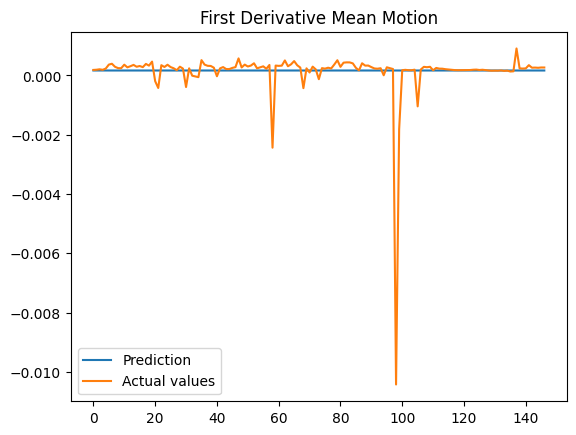

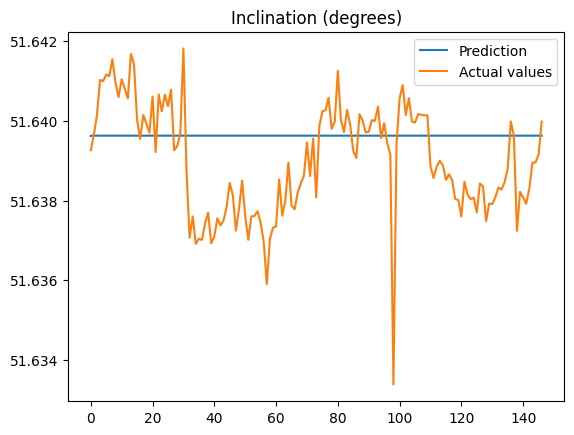

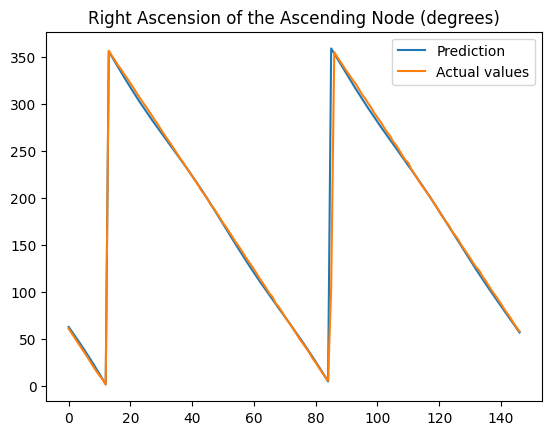

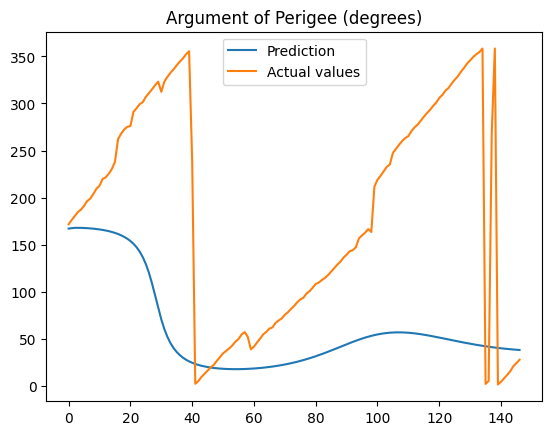

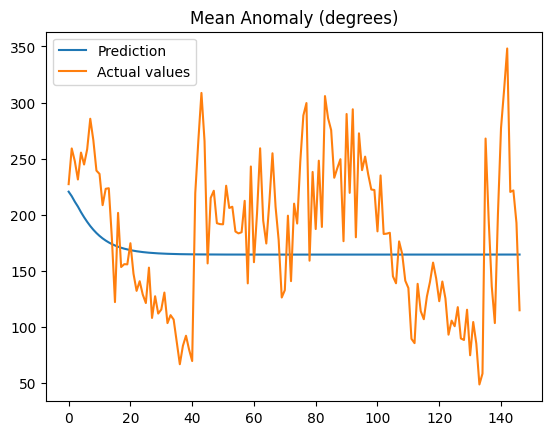

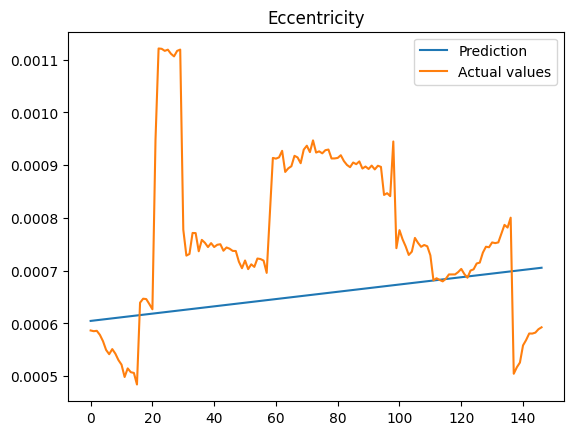

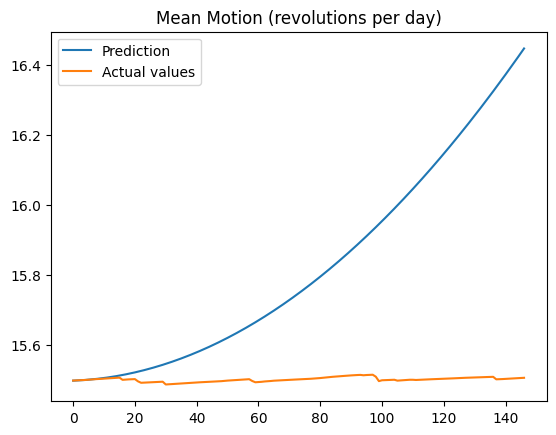

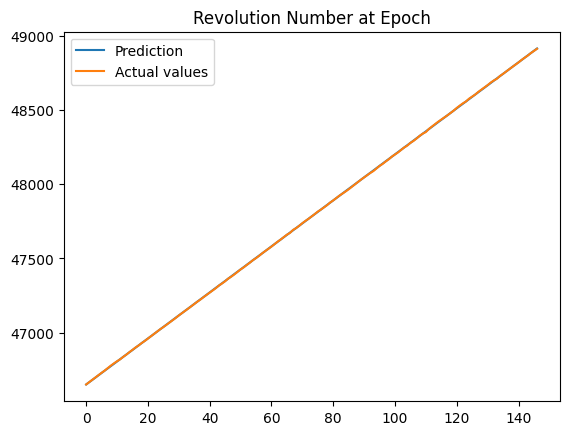

In [48]:
for i in range(num_features):
    actual_flat = y_actual[:, i].flatten()
    pred_flat = y_pred[:, i].flatten()
    
    plt.title(gt_features[i])
    plt.plot(pred_flat, label='Prediction')    
    plt.plot(actual_flat, label='Actual values')
    plt.legend()
    plt.show()